In [48]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from corolization import ResidualEncoder
import torch.nn.functional as F
import numpy as np
from skimage.color import rgb2yuv, yuv2rgb
import matplotlib.pyplot as plt
import os.path

In [42]:
train_dset = dsets.CIFAR10(root='./data/',
                               train=True, 
#                                transform=transforms.ToTensor(),
                               download=True)

# plt.imshow(yuv2rgb(rgb2yuv(np.array(train_dataset[0][0]))))
# plt.show()

test_dset = dsets.CIFAR10(root='./data/',
#                               transform=transforms.ToTensor(),
                              train=False)

Files already downloaded and verified


In [43]:
def massage_dset(dset):
    rtv = []
    for i, (image, _) in enumerate(dset):
        img = rgb2yuv(image)
        rtv.append((np.array(img[:, :, 0:1]).transpose(2, 0, 1), np.array(img[:, :, 1:]).transpose(2, 0, 1)))
    
    return rtv

train_dataset = massage_dset(train_dset)
test_dataset = massage_dset(test_dset)

In [45]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

In [49]:
encoder = ResidualEncoder(32)
if os.path.isfile('residual_encoder.pkl'):
    encoder.load_state_dict(torch.load('residual_encoder.pkl'))

In [50]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(torch.stack(images))
#         images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = encoder.double()(images)
#         outputs = encoder(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            torch.save(encoder.state_dict(), 'residual_encoder.pkl')
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


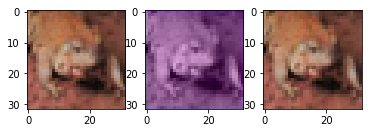

In [52]:
encoder.eval()
image, label = test_dataset[5]
image = Variable(torch.FloatTensor([image]))
output = encoder(image)

y_layer = image.data[0].numpy()
uv_pred = output.data[0].numpy()
uv_label = label

img_input = y_layer
img_pred = np.concatenate((y_layer, uv_pred), axis=0)
img_actual = np.concatenate((y_layer, uv_label), axis=0)

f, axarr = plt.subplots(1,3)
# axarr[0].imshow(yuv2rgb(img_input.reshape(32,32)), cmap='gray')
axarr[0].imshow(test_dset[5][0])
axarr[1].imshow(yuv2rgb(img_pred.transpose(1, 2, 0)))
axarr[2].imshow(yuv2rgb(img_actual.transpose(1, 2, 0)))
plt.show()